## Variational Auto  Encoders

- Reference: Adapted from the Keras example
- Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose, MaxPool2D, Dropout
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist

## Fashion MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 3s 1us/step


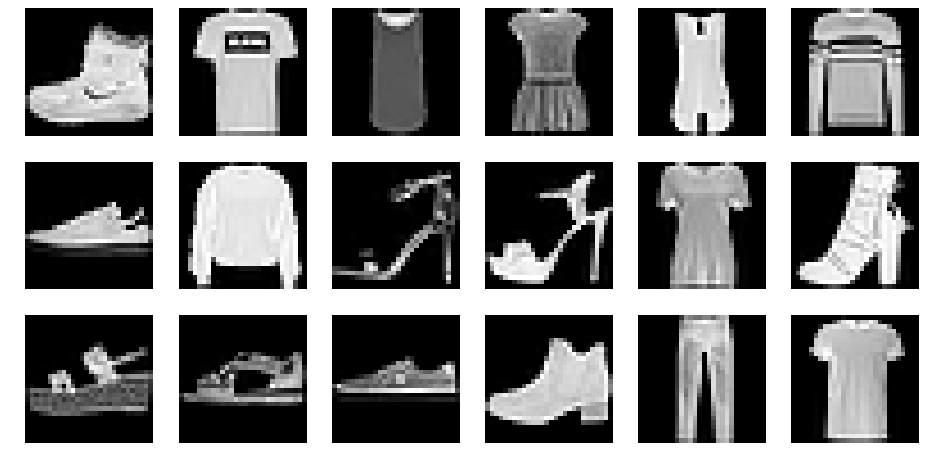

In [4]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

## Standard full-connected VAE model

Let's define a VAE model with fully connected MLPs for the encoder and decoder networks.

In [6]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### Encoder

In [ ]:
original_dim = 784 # Input dimension
latent_dim = 2 # for mu and sigma  (two outputs of dim2)
intermediate_dim = 256 
epsilon_std = 1.0


def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var],
                name="mlp_encoder")

    
encoder = make_encoder(original_dim, intermediate_dim, latent_dim)

### The VAE stochastic latent variable

<img src="https://github.com/imadelh/Deep-Learning-Labs/raw/master/Lab-10/images/vae_3.png" width="600px" />

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $$

The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x)$ instead of $\sigma_z(x)$. Taking the exponential of $log(\sigma^2_z(x)$ ensures the positivity of the standard deviation from the raw output of the network:

In [ ]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

### Decoder

In [ ]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")


decoder = make_decoder(latent_dim, intermediate_dim, original_dim)

By default the decoder outputs has random weights and output noise:

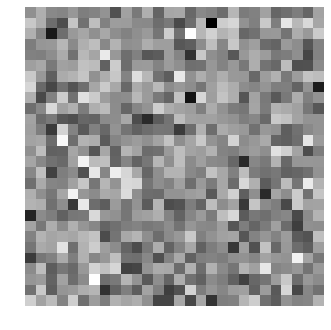

In [15]:
generated = decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

The generated image is completely univariate noise: there is no apparent spatial depenedencies between the pixel values. This reflects the lack of prior structure in the randomly initialized fully-connected decoder network. 


Let's now the plug the encoder and decoder via the stochastic latent variable $z$ to get the full VAE architecture. The loss function is the negative ELBO of the variational inference problem:

In [16]:
def make_vae(input_shape, encoder, decoder):
    # Build de model architecture by assembling the encoder,
    # stochastic latent variable and decoder:
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)

    # Define the VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(
        K.flatten(x), K.flatten(x_decoded_mean))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
mlp_encoder (Model)             [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           mlp_encoder[1][0]                
                                                                 mlp_encoder[1][1]                
__________________________________________________________________________________________________
mlp_decoder (Model)             (None, 784)          202256      latent_sampler[0][0]             
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Output "mlp_decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mlp_decoder" during training.


In [23]:
vae.fit(x_train_standard, epochs=100, batch_size=100,
        validation_data=(x_test_standard, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 65us/step - loss: 260.1562 - val_loss: 262.1589
Epoch 2/100
60000/60000 [==============================] - 4s 70us/step - loss: 260.0896 - val_loss: 262.0054
Epoch 3/100
60000/60000 [==============================] - 4s 69us/step - loss: 260.0926 - val_loss: 261.9372
Epoch 4/100
60000/60000 [==============================] - 4s 69us/step - loss: 260.0281 - val_loss: 262.0851
Epoch 5/100
 8800/60000 [===>..........................] - ETA: 3s - loss: 258.537560000/60000 [==============================] - 4s 69us/step - loss: 259.9917 - val_loss: 262.0901
Epoch 6/100
60000/60000 [==============================] - 4s 68us/step - loss: 259.8898 - val_loss: 261.8118
Epoch 7/100
60000/60000 [==============================] - 4s 69us/step - loss: 259.8579 - val_loss: 261.9303
Epoch 8/100
60000/60000 [==============================] - 4s 69us/step - loss: 259.8420 - val_loss: 261.9881

In [ ]:
# vae.save_weights("standard_weights.h5")

In [ ]:
vae.load_weights("standard_weights.h5")

Note that the model has not yet converged even after 50 epochs. Furthermore it's is not overfitting significantly either. We chose a very low value for the latent dimension. It is likely that using the higher dimensional space could lead to a model either to optimize that would better fit the training set.

By sampling a random latent vector from the prior distribution and feeding it to the decoder we can effectively sample from the image model trained by the VAE:

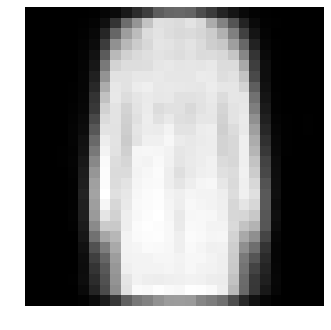

In [47]:
generated = decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

Use `Ctrl-Enter` several times to sample from various random locations in the 2D latent space.

The generated pictures are blurry but capture of the global organization of pixels required to represent samples from the 10 fashion item categories. The spatial structure has been learned and is only present in the decoder weights.

### 2D plot of the image classes in the latent space

We can also use the encoder to set the visualize the distribution of the test set in the 2D latent space of the VAE model. In the following the colors show the true class labels from the test samples.

Note that the VAE is an unsupervised model: it did not use any label information during training. However we can observe that the 2D latent space is largely structured around the categories of images used in the training set.

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

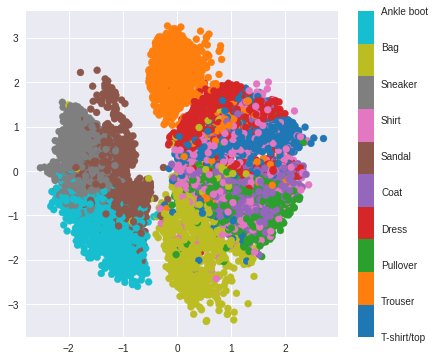

In [40]:
x_test_encoded, x_test_encoded_log_var = encoder.predict(x_test_standard, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

**Exercises**

- One can see that the class labels 5, 7 and 9 are grouped in a cluster of the latent space. Use matplotlib to display some samples from each of those 3 classes and discover why they have been grouped together by the VAE model.

- Similarly: can you qualitatively explain with matplotlib why class 0, 4 and 6 seem to be hard to disentangle in this 2D latent space discovered by the VAE model?

- One can observe that the global 2D shape of the encoded dataset is approximately spherical with values with a maximum radius of size 3. Where can you explain where the shape of this marginal latent distribution come from?

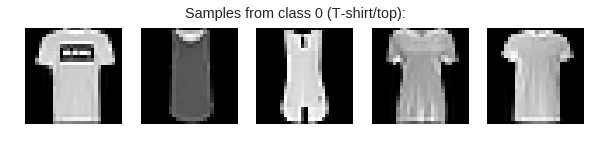

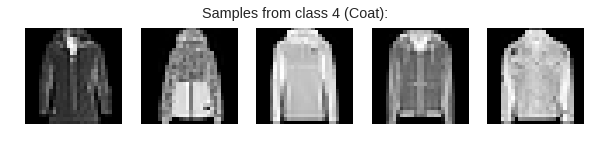

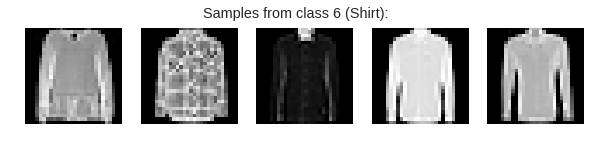

In [48]:
for i in [0, 4, 6]:
    plt.figure(figsize=(10, 2))
    for j in range(5):
        plt.subplot(1, 5, j + 1)
        plt.imshow(x_train[y_train == i][j], cmap="gray")
        plt.axis("off")
    plt.suptitle("Samples from class %d (%s):"
                 % (i, id_to_labels[i]))
    plt.show()

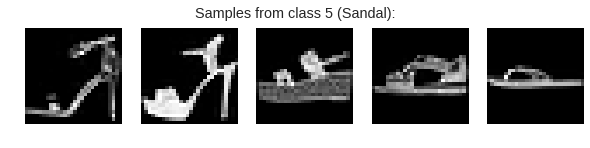

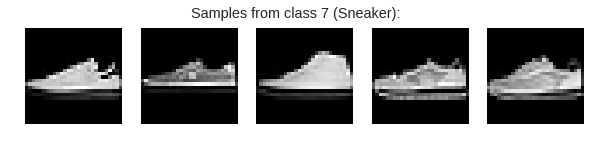

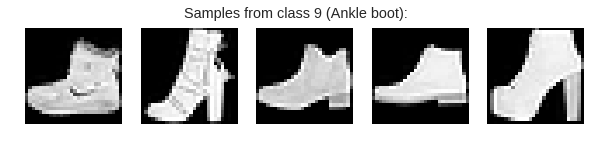

In [49]:
for i in [5, 7, 9]:
    plt.figure(figsize=(10, 2))
    for j in range(5):
        plt.subplot(1, 5, j + 1)
        plt.imshow(x_train[y_train == i][j], cmap="gray")
        plt.axis("off")
    plt.suptitle("Samples from class %d (%s):"
                 % (i, id_to_labels[i]))
    plt.show()

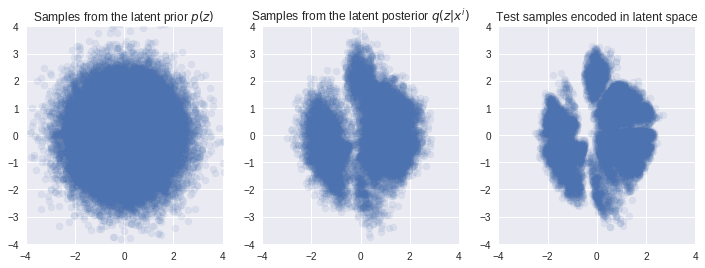

In [50]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))

# Sample from the latent variable prior
normal_data = np.random.normal(size=(x_train.shape[0], 2))
ax0.scatter(normal_data[:, 0], normal_data[:, 1], alpha=0.1)
ax0.set_title("Samples from the latent prior $p(z)$")
ax0.set_xlim(-4, 4)
ax0.set_ylim(-4, 4)

# Sample a z_i from the conditional posterior for each x_i in the test set:
z = np.vstack([
    np.random.multivariate_normal(
        x_test_encoded[i], np.diag(np.exp(x_test_encoded_log_var[i] / 2)))
    for i in range(x_test_encoded.shape[0])])
ax1.scatter(z[:, 0], z[:, 1], alpha=0.1)
ax1.set_title("Samples from the latent posterior $q(z|x^i)$")
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

# Posterior mean value for each sample x_i from the test set:
ax2.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.1)
ax2.set_title("Test samples encoded in latent space")
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4);

# Analysis:
#
# The VAE KL divergence term of the likelihood lower bound objective function
# is trying to force the encoder to match the posterior distribution with the
# prior of the latent variable. In our case we used:
#               Normal(mean=[0, 0], std=diag([1, 1])
# as the prior distribution which means that 99.7% of the points are expected
# to lie within a radius of 3 around the origin of the 2D latent plan.
#
# Selecting different location and scale parameters for the prior (or even
# a different distribution such as the uniform distribution) would impact the
# shape of the encoded data.

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

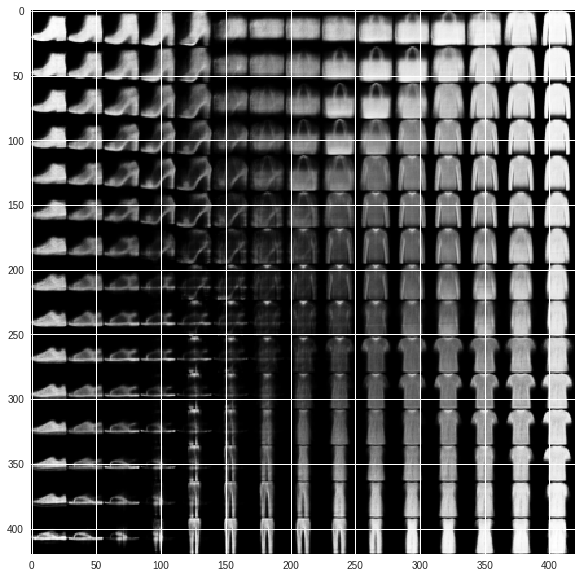

In [53]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Convolutional Variational Auto Encoder

In [54]:
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
x_train_conv.shape, x_test_conv.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

**Exercise**: write an encoder that uses a series of convolutional layers, with maxpooling or strided convolutions and Batch norm to encode the 2D, gray-level images into 2D latent vectors:

In [ ]:

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2


def make_conv_encoder(img_rows, img_cols, img_chns,
                      latent_dim, intermediate_dim):
    x_input = Input(shape=(img_rows, img_cols, img_chns))

    x = Conv2D(filters, kernel_size = kernel_size, activation="relu", padding="same")(x_input)
    x = Conv2D(filters, kernel_size = kernel_size, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) 
    
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x)
    
    x = Flatten()(x)
    
    x = Dropout(0.2)(x)
    
    x = Dense(50)(x)
    
    
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    

    return Model(inputs=x_input, outputs=[z_mean, z_log_var],
                 name='convolutional_encoder')


conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns,
                                 latent_dim, intermediate_dim)

In [76]:
conv_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 28, 28, 32)   320         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 

The stochastic latent variable is the same as for the fully-connected model.

In [ ]:
sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,),
                        name="latent_sampler")

## Decoder

The decoder is also convolutional but instead of downsampling the spatial dimensions from (28, 28) to 2 latent dimensions, it starts from the latent space to upsample a (28, 28) dimensions using strided `Conv2DTranspose` layers.

Here again BatchNormalization layers are inserted after the convolution to make optimization converge faster.

In [ ]:
from keras.layers import BatchNormalization

def make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                      spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)
    # First up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=(2, 2),
                        activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        padding='same',
                        strides=1,
                        activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Second up-sampling:
    x = Conv2DTranspose(filters,
                        kernel_size=3,
                        strides=(2, 2),
                        padding='valid',
                        activation='relu')(x)
    x = BatchNormalization()(x)
    # Ouput 1 channel of gray pixels values between 0 and 1:
    x = Conv2D(1, kernel_size=2, padding='valid',
               activation='sigmoid')(x)
    return Model(decoder_input, x, name='convolutional_decoder')


conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim,
                                 spatial_size=7, filters=filters)

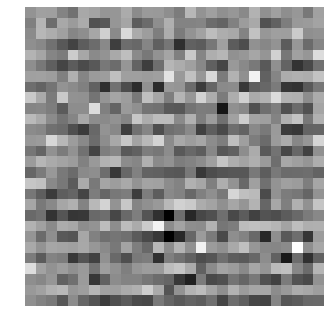

In [80]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

This new decoder encodes some a priori knowledge on the local dependencies between pixel values in the "deconv" architectures. Depending on the randomly initialized weights, the generated images can show some local spatial structure.

Try to re-execute the above two cells several times to try to see the kind of local structure that stem from the "deconv" architecture it-self for different random initializations of the weights.


Again, let's now plug everything to together to get convolutional version of a full VAE model:

In [81]:
input_shape = (img_rows, img_cols, img_chns)
vae = make_vae(input_shape, conv_encoder, conv_decoder)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
convolutional_encoder (Model)   [(None, 2), (None, 2 222046      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           convolutional_encoder[1][0]      
                                                                 convolutional_encoder[1][1]      
__________________________________________________________________________________________________
convolutional_decoder (Model)   (None, 28, 28, 1)    230913      latent_sampler[0][0]             
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Output "convolutional_decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "convolutional_decoder" during training.


In [82]:
vae.fit(x_train_conv, epochs=15, batch_size=100,
        validation_data=(x_test_conv, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 26s 431us/step - loss: 291.7062 - val_loss: 273.2119
Epoch 2/15
49000/60000 [=======================>......] - ETA: 4s - loss: 271.034060000/60000 [==============================] - 25s 414us/step - loss: 270.6956 - val_loss: 271.6681
Epoch 3/15
60000/60000 [==============================] - 25s 414us/step - loss: 267.9230 - val_loss: 268.4324
Epoch 4/15
27700/60000 [============>.................] - ETA: 12s - loss: 266.614560000/60000 [==============================] - 25s 414us/step - loss: 266.3611 - val_loss: 265.4211
Epoch 5/15
60000/60000 [==============================] - 25s 414us/step - loss: 265.0863 - val_loss: 264.7726
Epoch 6/15
22300/60000 [==========>...................] - ETA: 14s - loss: 264.348960000/60000 [==============================] - 25s 414us/step - loss: 264.1100 - val_loss: 267.0416
Epoch 7/15
60000/60000 [==============================] - 25s 414us/s

In [ ]:
# vae.save_weights("convolutional_weights.h5")

In [ ]:
vae.load_weights("convolutional_weights.h5")

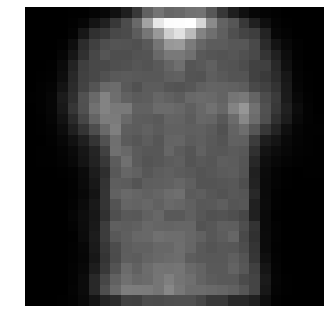

In [92]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

### 2D plot of the image classes in the latent space

We find again a similar organization of the latent space. Compared to the fully-connected VAE space, the differnt class labels seem slightly better separated. This could be a consequence of the slightly better fit we obtain from the convolutional models.

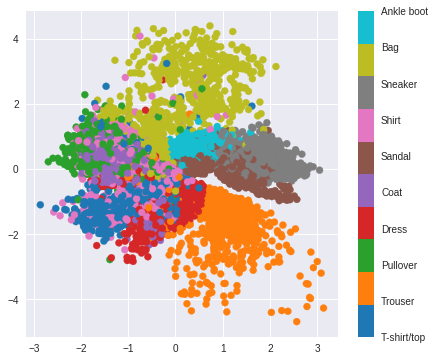

In [94]:
x_test_encoded, _ = conv_encoder.predict(x_test_conv, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

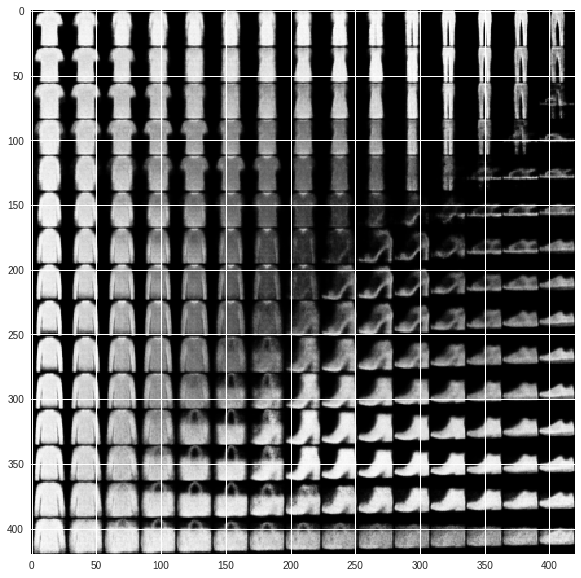

In [95]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = conv_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Semi-supervised learning (Stopped Here)

Let's reuse our encoder trained on many unlabeled samples to design a supervised model that can only use supervision from a small subset of samples with labels.

To keep things simple we will just build a small supervised model on top of the latent representation defined by our encoder.

We assume that we only have access to a small labeled subset with 50 examples per class (instead of 5000 examples per class in the full Fashion MNIST training set):

In [96]:
rng = np.random.RandomState(42)

small_x_train = []
small_y_train = []
num_per_class = 50

for c in range(10):
    class_mask = np.where(y_train==c)[0]
    idx = rng.choice(class_mask, size=num_per_class, replace=False)
    small_x_train += [x_train_conv[idx]]
    small_y_train += [c] * num_per_class

small_x_train = np.vstack(small_x_train)
small_y_train = np.array(small_y_train)

# reshuffle our small dataset
perm = rng.permutation(range(small_y_train.shape[0]))
small_x_train = small_x_train[perm]
small_y_train = small_y_train[perm]

small_x_train.shape, small_y_train.shape

((500, 28, 28, 1), (500,))

**Exercise:**

- Use `conv_encoder` to project `small_x_train` into the latent space;
- Define a small supervised 10-class classification network and use `small_y_train` to train it;
- What test accuracy can you reach? What is the chance level?
- Suggest what could be changed to improve the quality of our classification on this small labeled dataset.

In [ ]:
# TODO: implement me!
# define `small_x_train_encoded` for in the input training data
# define a model named `mdl` with its layers and its loss function.

In [ ]:
from keras.layers import Dropout

# Use the VAE encoder to project the small training set into the latent space
small_x_train_encoded, _ = conv_encoder.predict(small_x_train, batch_size=100)

# Define a small MLP that takes the 2D vectors as input.
inp = x = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(10, activation="softmax")(x)
mdl = Model(inp, x)
mdl.compile(loss="sparse_categorical_crossentropy",
            optimizer="adam", metrics=["acc"])

In [ ]:
print(mdl.summary())

In [ ]:
mdl.fit(small_x_train_encoded, small_y_train, 
        epochs=30, validation_data=[x_test_encoded, y_test])

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = mdl.predict(x_test_encoded).argmax(axis=-1)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = [name for id, name in sorted(id_to_labels.items())]
plot_confusion_matrix(cnf_matrix, classes=class_names)

### Going further

- Retrain the conv/deconv VAE model with a latent dim of 30 instead of 2. Generating the 2D manifold panels plots is no longer possible. However this richer latent space should make it possible to reach a much better test likelihood bound and generate higher quality images.

- Adapt the convolutional architecture to retrain the model on the labeled faces in the wild (LFW) dataset instead (GPU needed).